<a href="https://colab.research.google.com/github/mvish7/traffic_sign_classifier/blob/master/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All the necessary imports

In [15]:
import pickle
from google.colab import files
import io
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


Fetching the data

In [0]:
def load_data(training_data_file, testing_data_file):
    with open(training_data_file, mode='rb') as f:
        train_data = pickle.load(f)
    with open(testing_data_file, mode='rb') as f:
        test_data = pickle.load(f)
    return train, test

In [5]:
drive.mount('/content/drive')
data_path="/content/drive/My Drive/traffic_sign_classifier_data/"

training_data_file= open(data_path+'train.p','rb')
test_data_file= open(data_path+'test.p','rb')
valid_data_file=open(data_path+'valid.p', 'rb')

train_data = pickle.load(training_data_file)
test_data = pickle.load(test_data_file)
valid_data = pickle.load(valid_data_file)

X_train, y_train = train_data['features'], train_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
X_valid,y_valid = valid_data['features'], valid_data['labels']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Pickled data is a dict having 4 key-values paris, namely
features, labels, size and coords

problem with coords --- it considers original image and pickled data has 32*32 downsampled image (this ate my head all the way)



---

Getting to know the data

In [6]:

# Number of examples
n_train, n_test = X_train.shape[0], X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many classes?
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples  =", n_test)
print("Image data shape  =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples  = 12630
Image data shape  = (32, 32, 3)
Number of classes = 43




---

Visualize some samples

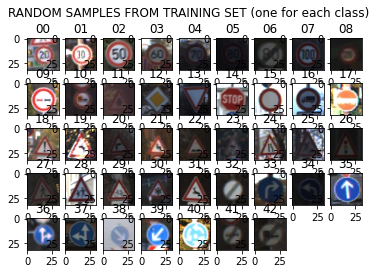

In [7]:
%matplotlib inline

# showing a random sample from each class
rows, cols = 5, 9
fig, ax_array = plt.subplots(rows, cols)
plt.suptitle('RANDOM SAMPLES FROM TRAINING SET (one for each class)')


for class_idx, ax in enumerate(ax_array.ravel()):
    if class_idx < n_classes:
        # show a random image of the current class
        cur_X = X_train[y_train == class_idx]
        cur_img = cur_X[np.random.randint(len(cur_X))]
        ax.imshow(cur_img)
        ax.set_title('{:02d}'.format(class_idx))
    else:
        ax.axis('off')
      
plt.draw()



Preprocessing the data
doing the normalization (image centering to zero image and dividing by std_div)

In [0]:
def data_preprocess(X):


    X = np.float32(X)

    # standardize features
    X -= np.mean(X)
    X /= (np.std(X) + np.finfo('float32').eps)

    return X


X_train = np.array([data_preprocess(img) for img in X_train])

X_test = np.array([data_preprocess(img) for img in X_test])

X_valid = np.array([data_preprocess(img) for img in X_valid])


Defining model architecture
LeNet 5 which is taught in Udacity course is used here
paper of a model related to same problem is at http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

In [0]:
def forward_pass(x):
    """Perform a forward pass through the network
    
    Parameters
    ----------
    x : Tensor
        the input data
        
    Returns
    -------
    Tensor
        the logits
        
    """
    # Arguments used for tf.truncated_normal --> used to randomly define the weights and biases
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    w1 = tf.Variable(tf.truncated_normal([5, 5, 3, 6], mean=mu, stddev=sigma))
    b1 = tf.Variable(tf.zeros(6))
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    h1 = tf.nn.conv2d(x, w1, strides, padding) + b1

    # Activation.
    a1 = tf.nn.dropout(tf.nn.relu(h1), keep_prob)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    ksize = [1, 2, 2, 1]
    strides = [1, 2, 2, 1]
    padding = 'SAME'
    a2 = tf.nn.dropout(tf.nn.max_pool(a1, ksize, strides, padding), keep_prob)
    

    # Layer 2: Convolutional. Output = 10x10x16.
    w3 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma))
    b3 = tf.Variable(tf.zeros(16))
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    h3 = tf.nn.conv2d(a2, w3, strides, padding) + b3

    # Activation.
    a3 = tf.nn.dropout(tf.nn.relu(h3), keep_prob)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    ksize = [1, 2, 2, 1]
    strides = [1, 2, 2, 1]
    padding = 'SAME'
    a4 = tf.nn.dropout(tf.nn.max_pool(a3, ksize, strides, padding), keep_prob)

    # Flatten. Input = 5x5x16. Output = 400.
    a5 = tf.layers.flatten(a4)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    w6 = tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma))
    b6 = tf.Variable(tf.zeros(120))
    h6 = tf.add(tf.matmul(a5, w6), b6)

    # Activation.
    a6 = tf.nn.dropout(tf.nn.relu(h6), keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    w7 = tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma))
    b7 = tf.Variable(tf.zeros(84))
    h7 = tf.add(tf.matmul(a6, w7), b7)

    # Activation.
    a7 = tf.nn.dropout(tf.nn.relu(h7), keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    w8 = tf.Variable(tf.truncated_normal([84, 43], mean=mu, stddev=sigma))
    b8 = tf.Variable(tf.zeros(43))

    return tf.add(tf.matmul(a7, w8), b8)

In [0]:

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, 43)

In [0]:
EPOCHS = 50
BATCH_SIZE = 128
rate = 0.001

In [21]:

logits = forward_pass(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
prediction = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


In [0]:

def evaluate(X_data, y_data):
    """Calculate the accuracy of the model
    
    Parameters
    ----------
    X_data : Tensor
        the input data
    y_data : Tensor
        the labels for the input data
        
    Returns
    -------
    float
        the accuracy of the model
    
    """
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [24]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.9})

        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './traffic-signs')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.799

EPOCH 2 ...
Validation Accuracy = 0.885

EPOCH 3 ...
Validation Accuracy = 0.920

EPOCH 4 ...
Validation Accuracy = 0.932

EPOCH 5 ...
Validation Accuracy = 0.929

EPOCH 6 ...
Validation Accuracy = 0.935

EPOCH 7 ...
Validation Accuracy = 0.946

EPOCH 8 ...
Validation Accuracy = 0.940

EPOCH 9 ...
Validation Accuracy = 0.936

EPOCH 10 ...
Validation Accuracy = 0.946

EPOCH 11 ...
Validation Accuracy = 0.946

EPOCH 12 ...
Validation Accuracy = 0.941

EPOCH 13 ...
Validation Accuracy = 0.942

EPOCH 14 ...
Validation Accuracy = 0.952

EPOCH 15 ...
Validation Accuracy = 0.943

EPOCH 16 ...
Validation Accuracy = 0.952

EPOCH 17 ...
Validation Accuracy = 0.949

EPOCH 18 ...
Validation Accuracy = 0.948

EPOCH 19 ...
Validation Accuracy = 0.951

EPOCH 20 ...
Validation Accuracy = 0.951

EPOCH 21 ...
Validation Accuracy = 0.945

EPOCH 22 ...
Validation Accuracy = 0.953

EPOCH 23 ...
Validation Accuracy = 0.948

EPOCH 24 ...
Validation Accura